In [104]:
import sys
base_dir = "D:/Thesis/Cobra/cobra/"
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
from utilities import utils, stats
from stats_tools import vis as svis
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Load df and convert string to date and time

In [2]:
table_dir = join(base_dir, 'data/tables')
df = utils.load_scan_csv(join(table_dir, 'neg_pos.csv'))
D_k = 'InstanceCreationDate'
T_k = 'InstanceCreationTime'
def convert_to_date(x):
    try:
        return dt.strptime(x, "%Y-%m-%d").date()
    except:
        return pd.NaT
def convert_to_time(x):
    try:
        return dt.strptime(x, "%H:%M:%S").time()
    except:
        return pd.NaT
df.InstanceCreationDate = df.InstanceCreationDate.map(lambda x: convert_to_date(x))
df.InstanceCreationTime = df.InstanceCreationTime.map(lambda x: convert_to_time(x))

C:\Users\klein\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  


## Search for dates in Series Description

In [50]:
mask_missing_dates = df.InstanceCreationDate.isnull()
df_missing_date = df[mask_missing_dates]
print(len(df_missing_date), 'volumes have no date given')

54325 volumes have no date given


In [68]:
print(len(df_missing_date[stats.check_tags(df_missing_date, ['\d\d-'])].SeriesDescription))
print(len(df_missing_date[stats.check_tags(df_missing_date, ['\d\d:\dd'])].SeriesDescription))

0
0


No volumes for which the series description matches the pattern of a date or time

# Check if scans from same study can have different dates

## Plot difference in days distribution for each study

In [5]:
study_date_count = df_n.dropna(subset=['InstanceCreationDate']).groupby('StudyInstanceUID')['InstanceCreationDate'].nunique()
mask_diff_days = study_date_count[study_date_count>1]
df_different_dates = df_n[df_n.StudyInstanceUID.isin(mask_diff_days.index)]
df_different_dates = df_different_dates.dropna(subset=['InstanceCreationDate'])
gb_sid = df_different_dates.groupby('StudyInstanceUID')
first_day = gb_sid['InstanceCreationDate'].min()

In [6]:
differences = []
for index, row in df_different_dates.iterrows():
    differences.append((row['InstanceCreationDate'] - first_day[row['StudyInstanceUID']]).days)
differences = np.array(differences)

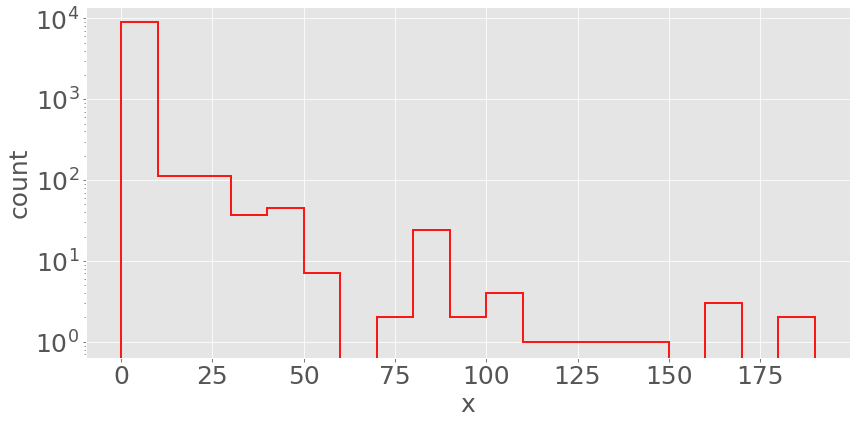

In [17]:
_ = svis.hist(differences, np.arange(0,200,10), kwargs={'ylogscale':True})

## -> because of the date differences within a study folder, we cannot replace missing values by the other dates in the study

# Plot scan dates

C:\Users\klein\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


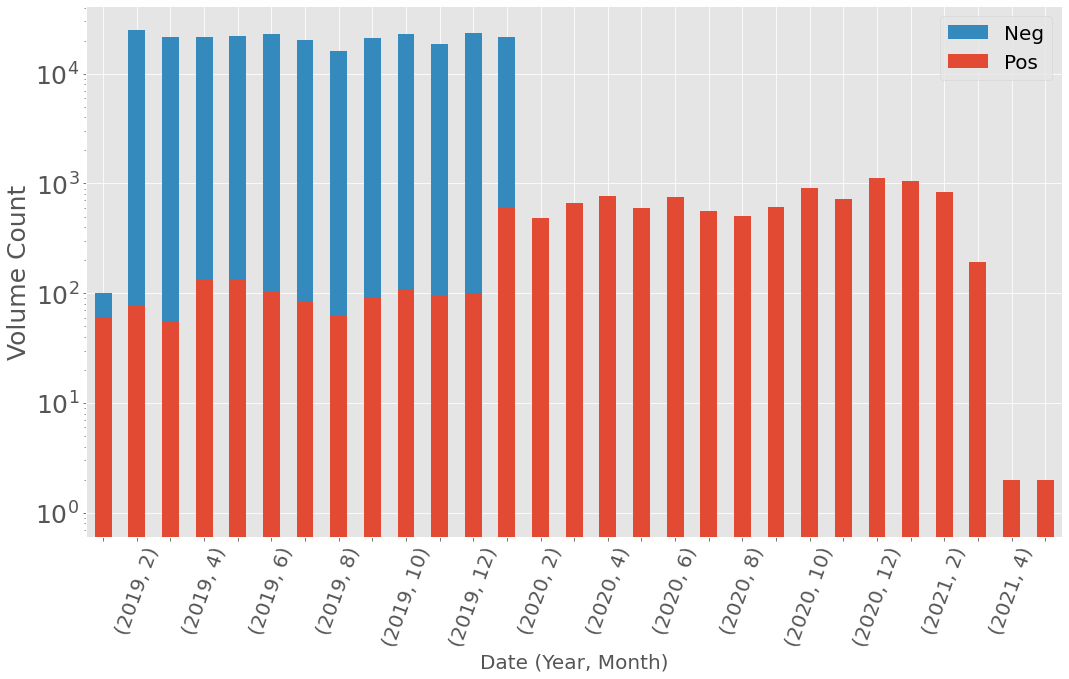

In [ ]:
#Now remove all the missing dates
df = df[~mask_missing_dates]
df["InstanceCreationDate"] = df["InstanceCreationDate"].astype("datetime64")
df_p = df[df.Pos==1]
df_n = df[df.Pos==0]
plt.style.use('ggplot')
fig, ax = svis.plot_decorator(df_n.groupby([df_n["InstanceCreationDate"].dt.year, \
    df_n["InstanceCreationDate"].dt.month]).Rows.count().plot, 
    figsize=(15,10),
    plot_func_kwargs={'kind':'bar','label':'Neg', 
        'color':svis.Color_palette(0)[1],} ,
    kwargs={'xtickparams_rot':80, 'ylabel':'Volume Count','ylogscale':True,
    })
ax = df_p.groupby([df_p["InstanceCreationDate"].dt.year, \
    df_p["InstanceCreationDate"].dt.month]).Rows.count().plot(kind="bar", 
    color=svis.Color_palette(0)[0], ax=ax, label='Pos')
ax.tick_params(axis='x', which='major', labelsize=20, rotation=70)
ax.set_xlabel('Date (Year, Month)', fontsize=20)
ax.legend(fontsize=20)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


In [95]:
def combine_date_time(a, b):
    try:
        return dt.combine(a, b)
    except:
        return pd.NaT
    
s = df.apply(lambda x: combine_date_time(a = x[D_k], b = x[T_k]), axis=1).values